In [ ]:
%autosave 10

Autosaving every 10 seconds


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import os
import random
import numpy as np
import re
import string
from string import digits
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import matplotlib.pyplot as plt


from nltk.translate.bleu_score import sentence_bleu

In [ ]:
os.chdir("/content/drive/My Drive/NeuralMT")
os.listdir()

['en_hi.pkl',
 'data',
 'data_small',
 'seq2seq_0.31.params',
 'seq2seq_0.26.params']

#With Punctuation


##data prep


In [ ]:
import re
import string
from string import digits

In [ ]:
# import pandas as pd
df = pd.read_pickle('en_hi.pkl')

In [ ]:
df.head(20)

,english,hindi
57382,Who is this man?\n,-ये आदमी कौन है ?\n
28149,And the other brother?\n,और दूसरे भाई?\n
80284,"- Greetings, Mustakeen bhai.\n","नमस्ते, Mustakeen भाई।\n"
63596,"Please, reason with them.\n","कृपया, उन लोगों के साथ कारण.\n"
9459,There's a howling gale.\n,तेज़ हवा आ रही है।\n
67410,"- No, you don't.\n","- नहीं , कभी नहीं .\n"
89506,"the violence, the rage.\n","हिंसा, स्पूर्ति।\n"
71637,Signal decoy in place.\n,सिग्नल जगह में लूभाव।\n
66488,You guys come with?\n,तुम लोग इसे ले तो आये हो ?\n
52809,How long you staying?\n,तुम कब तक रह?\n


In [ ]:
lines = df.copy()
# general
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'t", " not", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"\'re", " are", x))
# lines['english']=lines['english'].apply(lambda x: re.sub(r"\'s", " is", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'d", " would", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'ll", " will", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'ve", " have", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'m", " am", x))

lines['hindi'] = lines['hindi'].apply(lambda x: x.replace('.',' ।'))
# lines['hindi'] = lines['hindi'].apply(lambda x: x.replace('।',' ।'))

# lines['english']=lines['english'].apply(lambda x: re.sub(r"n\in'", "ing", x))

# Lowercase all characters
lines['english']=lines['english'].apply(lambda x: x.lower())
lines['hindi']=lines['hindi'].apply(lambda x: x.lower())


exclude = set(['$','&','+',':',';','=','@','|','<','>','^','*','%','-','#','\'']) # Set of all special characters
# Remove all the special characters
lines['english']=lines['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi']=lines['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))


# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english']=lines['english'].apply(lambda x: x.translate(remove_digits))
lines['hindi']=lines['hindi'].apply(lambda x: x.translate(remove_digits))

lines['hindi'] = lines['hindi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english']=lines['english'].apply(lambda x: x.strip())
lines['hindi']=lines['hindi'].apply(lambda x: x.strip())
lines['english']=lines['english'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi']=lines['hindi'].apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines['hindi'] = lines['hindi'].apply(lambda x :  x + '\n')

lines['english'] = lines['english'].apply(lambda x : x + '\n')
lines.head(20)

,english,hindi
57382,who is this man?\n,ये आदमी कौन है ?\n
28149,and the other brother?\n,और दूसरे भाई?\n
80284,"greetings, mustakeen bhai.\n","नमस्ते, mustakeen भाई।\n"
63596,"please, reason with them.\n","कृपया, उन लोगों के साथ कारण ।\n"
9459,theres a howling gale.\n,तेज़ हवा आ रही है।\n
67410,"no, you do not.\n","नहीं , कभी नहीं ।\n"
89506,"the violence, the rage.\n","हिंसा, स्पूर्ति।\n"
71637,signal decoy in place.\n,सिग्नल जगह में लूभाव।\n
66488,you guys come with?\n,तुम लोग इसे ले तो आये हो ?\n
52809,how long you staying?\n,तुम कब तक रह?\n


In [ ]:
# train, validate, test = np.split(lines.sample(frac=1), [int(.7*len(df)), int(.8*len(df))])
# print(train.shape, validate.shape, test.shape)

(7000, 2) (1000, 2) (2000, 2)


In [ ]:
train, test = np.split(lines.sample(frac=1), [int(.8*len(df))])


In [ ]:
# with open('/content/drive/My Drive/NeuralMT/data/dev.en', 'w') as writefile:
#     writefile.write(('').join(validate['english']))
# with open('/content/drive/My Drive/NeuralMT/data/dev.hi', 'w') as writefile:
#     writefile.write(('').join(validate['hindi']))
with open('/content/drive/My Drive/NeuralMT/data/test.en', 'w') as writefile:
    writefile.write(('').join(test['english']))
with open('/content/drive/My Drive/NeuralMT/data/test.hi', 'w') as writefile:
    writefile.write(('').join(test['hindi']))
with open('/content/drive/My Drive/NeuralMT/data/train.en', 'w') as writefile:
    writefile.write(('').join(train['english']))
with open('/content/drive/My Drive/NeuralMT/data/train.hi', 'w') as writefile:
    writefile.write(('').join(train['hindi']))

# with open('/content/drive/My Drive/NeuralMT/data_small/dev.en', 'w') as writefile:
#     writefile.write(('').join(validate['english']))
# with open('/content/drive/My Drive/NeuralMT/data_small/dev.hi', 'w') as writefile:
#     writefile.write(('').join(validate['hindi']))
# with open('/content/drive/My Drive/NeuralMT/data_small/test.en', 'w') as writefile:
#     writefile.write(('').join(test['english']))
# with open('/content/drive/My Drive/NeuralMT/data_small/test.hi', 'w') as writefile:
#     writefile.write(('').join(test['hindi']))
# with open('/content/drive/My Drive/NeuralMT/data_small/train.en', 'w') as writefile:
#     writefile.write(('').join(train['english']))
# with open('/content/drive/My Drive/NeuralMT/data_small/train.hi', 'w') as writefile:
#     writefile.write(('').join(train['hindi']))

##dataset prep and other functions common to all models


In [ ]:
data_folder = "data"
files = os.listdir(data_folder)
source_files = [os.path.join(data_folder, file) for file in files if ".en" in file]
target_files = [os.path.join(data_folder, file) for file in files if ".hi" in file]
print(source_files)

def generate_vocab(filenames):
    vocab = set()
    # no_words = 0
    for file in filenames:
        content = open(file).read()
        sentences = [re.sub(fr'([{string.punctuation}])\B', r' \1', sentence).split() for sentence in content.split('\n')]
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab.add(word)
                    # no_words += 1

    vocab = {word: num for num, word in enumerate(vocab)}
    return vocab

def parse_files_to_indices(filename, vocab):
    content = open(filename).read()
    return [[vocab[word] for word in re.sub(fr'([{string.punctuation}])\B', r' \1', sentence).split() if word in vocab] for sentence in content.split('\n')]

class Dataset:
    def __init__(self, source_files, target_files, batch_size=10):
        self.source_vocab = generate_vocab(source_files) #for entire lang
        self.target_vocab = generate_vocab(target_files) #for entire lang
        
        self.len_source = len(self.source_vocab.keys())
        self.source_pad, self.source_start, self.source_end = self.len_source + 2, self.len_source + 1, self.len_source
        self.len_target = len(self.target_vocab.keys())
        self.target_pad, self.target_start, self.target_end = self.len_target + 2, self.len_target + 1, self.len_target
        
        self.source_vocab['<pad>'], self.source_vocab['<start>'], self.source_vocab['<end>'] = [self.source_pad, 
                                                                                                self.source_start, 
                                                                                                self.source_end]
        self.target_vocab['<pad>'], self.target_vocab['<start>'], self.target_vocab['<end>'] = [self.target_pad,
                                                                                                self.target_start, 
                                                                                                self.target_end]
                                                                                              
        ##created indices for <pad>, <start> and <end> tokens
        self.len_source = len(self.source_vocab.keys())
        self.len_target = len(self.target_vocab.keys())
        
        ##inverse vocab for entire lang
        self.source_vocab_inv = {value:key for key, value in self.source_vocab.items()}
        self.target_vocab_inv = {value:key for key, value in self.target_vocab.items()}
        
        ##parsing files into indices
        for filename in source_files:
            if 'train' in filename:
                self.source_train = parse_files_to_indices(filename, self.source_vocab)
            if 'test' in filename:
                self.source_test = parse_files_to_indices(filename, self.source_vocab)
            # if 'dev' in filename:
            #     self.source_dev = parse_files_to_indices(filename, self.source_vocab)
                
        for filename in target_files:
            if 'train' in filename:
                self.target_train = parse_files_to_indices(filename, self.target_vocab)
            if 'test' in filename:
                self.target_test = parse_files_to_indices(filename, self.target_vocab)
            # if 'dev' in filename:
            #     self.target_dev = parse_files_to_indices(filename, self.target_vocab)
                
        ##random shuffling of training data before splitting into batches    
        self.indices = list(range(len(self.source_train)))
        random.shuffle(self.indices)
        self.current = -batch_size
        self.batch_size = batch_size
        
    def __get_batch_input(self, indices):
        source, target_input, target_target = [], [], []
        
        # padding length of sentence
        source_max_len = max(len(self.source_train[i]) for i in indices)
        target_max_len = max(len(self.target_train[i]) for i in indices)
        
        for i in indices:
            length = len(self.source_train[i])
            # reverse_source_sentences and pad at beginning
            sentence = [self.source_pad for _ in range(source_max_len - length)] + [self.source_end] + self.source_train[i][::-1] + [self.source_start]
            source.append(sentence)
            
            length = len(self.target_train[i])
            # padding at end for target
            sentence = [self.target_start] + self.target_train[i] + [self.target_end] + [self.target_pad for _ in range(target_max_len - length)]
            target_input.append(sentence)
            #removed <sos> and put <pad> at end
            target_target.append(sentence[1:] + [self.target_pad])
            
        return np.array(source), np.array(target_input), np.array(target_target)
    
    def get_batch_input(self):
        if self.current > len(self.indices) - self.batch_size:
            self.current = 0
            return None, None, None
        self.current += self.batch_size
        return self.__get_batch_input(self.indices[self.current: self.current + self.batch_size])
    
    def convert_indices_to_words(self, indices):
        output = []
        for sentence in indices:
            s = []
            for word in sentence:
                if word == self.target_end:
                  break
                s.append(self.target_vocab_inv[word])
            output.append(s)
        return output

    def convert_indices_to_words_eng(self, indices):
        output = []
        for sentence in indices:
            s = []
            for word in sentence:
                s.append(self.source_vocab_inv[word])
            output.append(s)
        return output


def train(model, dataset, coverage=False, coverage_type="linguistic", iterations=1, use_teacher_forcing=True, log=True):

    loss_func = nn.NLLLoss()
    attn_loss_func = nn.MSELoss()
    
    optimizer = optim.Adagrad(model.parameters()) 
    
    for i in range(iterations):
        iter_loss = 0
        while True:
            
            optimizer.zero_grad() #set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
            source, target_input, target_output = d.get_batch_input() #sentences made into indices and padded to sentence lenght 

            if source is None: # end of current iteration
                break

            source, target_input, target_output = [torch.LongTensor(source), 
                                                   torch.LongTensor(target_input), 
                                                   torch.LongTensor(target_output)]
            
            source_mask = torch.ones(source.shape)
            source_mask[source == dataset.source_pad] = 0
            
            if use_teacher_forcing:
                pred = model(source, target_input, source_mask=source_mask)
                # mask whatevers after <stop> 
                target_mask = torch.ones(target_output.shape)
                target_mask[target_output == dataset.target_pad] = 0

                pred = pred * target_mask.unsqueeze(-1)
                target_output = target_output * target_mask.long()
            else:
                pred = model(source)
                
            no_words = pred.shape[0] * pred.shape[1]
            pred = pred.reshape(no_words, -1)
            target_output = target_output.reshape(no_words)

            pred_error = loss_func(pred, target_output)
            iter_loss += pred_error
            # print("loss ", pred_error)
            attn_error = None

                
            pred_error.backward() #backward prop
            optimizer.step()
            
            if log:
                print(d.current/d.batch_size, pred_error, end='\r')
        print("loss ", iter_loss)
        # loss.append(iter_loss)
    return iter_loss


def convert_pred_to_indices(pred):
    # print('pred',pred.shape)
    # print('pred_ideal',torch.max(pred, dim=-1)[1].shape)
    # print(torch.max(pred, dim=-1)[1])
    return torch.max(pred, dim=-1)[1]


def eval(model, dataset, log=False, source_test=None, target_test=None):
    scores = []

    if source_test is None:
        source_test = dataset.source_test
        target_test = dataset.target_test
        
    for sentence, target in zip(source_test, target_test):
        input_text = dataset.convert_indices_to_words_eng([sentence[::-1]] )
        input = torch.LongTensor([[dataset.source_end] + sentence[::-1] + [dataset.source_start]])

        pred, _ = model(input)
        pred_words = convert_pred_to_indices(pred).cpu().numpy()
        
        predicted_target = dataset.convert_indices_to_words(pred_words)
        target = dataset.convert_indices_to_words([target])
        if log:
            print("Input: ",' '.join(input_text[0][::-1]))
            print("Target: ", ' '.join(target[0]))
            print("Output: ", ' '.join(predicted_target[0]))
            print()
            # print(input_text,target, predicted_target[0])
        scores.append(sentence_bleu(target, predicted_target[0], weights=(1, 0, 0, 0)))
    return sum(scores)/len(scores)

def train_and_save(m, d, str_, log=False):
    prev_score = -1
    loss = []
    score = []

    for i in range(20):
        iter_loss = train(m, d, log=log)
        iter_score = eval(m, d, log=True)

        loss.append(iter_loss)
        score.append(iter_score)

        best_state = None
        print()
        print(score)
        if iter_score > prev_score:
            #torch.save(m.state_dict(), str_ + str(score)[:4] + ".params_")
            best_state = m.state_dict()
            prev_score = iter_score
            
    torch.save(best_state, str_ + str(prev_score)[:4] + ".params")
    print(prev_score)

    plt.plot(np.arange(20), loss, marker='o')
    plt.xlabel('epochs')
    plt.ylabel('cost')
    plt.show()
    plt.plot(np.arange(20), score, marker='o')
    plt.xlabel('epochs')
    plt.ylabel('score')
    plt.show()

['data/test.en', 'data/train.en']


##seq2seq

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, padding_dim=0):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        
    def forward(self, input):
        '''
        input dim => 2d; no_sentences * no_words in sentence (indices)  
        make sure that the input is in reverse
        
        Outputs:
        output, h, c
        
        output => dim: (num_sentences * no_words * hidden_dim)
        h => (num_layers * num_sentences * hidden_dim)
        c => (num_layers * num_sentences * hidden_dim)
        '''
        embeddings = self.embedding(input) #embeddings => no_sentences * no_words in sentence (indices) * embedding_dim
        output, (h, c) = self.encoder(embeddings) 
        
        return output, h, c


class Decoder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, padding_dim=0, start_dim=1):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_dim)
        self.decoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.word_predictor = nn.Linear(hidden_dim, num_embeddings)
        self.start_dim = start_dim
        
    def forward(self, output, h, c, input=None, max_sen_len=20):
        '''
        Input:
        word predictor: N,*,hidden_dim(Input sample size) => N,*,num_embedding(Output Sample Size )

        Output:
        pred: (no_sentences * no_words * no_embeddings)

        return prediction prob for each word_space in each sentence
        '''
        
        if input is not None: # training with teacher forcing
            
            embeddings = self.embedding(input)
            yts, _ = self.decoder(embeddings, (h, c))
            orig_shape = yts.shape
            # print("orig_shape",orig_shape, orig_shape[:-1],"nfk ", *orig_shape[:-1])
            pred = self.word_predictor(yts.reshape(orig_shape[0]*orig_shape[1], -1)).reshape(*orig_shape[:-1], -1)
            return torch.log_softmax(pred, dim=-1), None 
        
        else: # training using the decoders' own predictions
            
            num_sentences = output.shape[0]
            words_selected = torch.LongTensor([[self.start_dim] for _ in range(num_sentences)])
            pred = []
            for i in range(max_sen_len):
                embeddings = self.embedding(words_selected)
                y_t, (h, c) = self.decoder(embeddings, (h, c))
                orig_shape = y_t.shape
                pred_t = self.word_predictor(y_t.reshape(orig_shape[0]*orig_shape[1], 
                                                         -1)).reshape(*orig_shape[:-1], -1).squeeze(1)

                pred.append(pred_t)
                words_selected = torch.max(pred_t, dim=1)[1].unsqueeze(1)
            
            pred = torch.stack(pred, dim=1)
            return torch.log_softmax(pred, dim=-1)

class Seq2Seq(nn.Module):
    def __init__(self, source_vocab_len, target_vocab_len, embedding_dim, hidden_dim, num_layers=1,
                       padding_dim_source=0, start_dim_target=1, padding_dim_target=0):
        super().__init__()
        self.encoder = Encoder(source_vocab_len, embedding_dim, hidden_dim, num_layers, padding_dim_source)
        self.decoder = Decoder(target_vocab_len, embedding_dim, hidden_dim, num_layers, padding_dim_target, start_dim_target)
        
    def forward(self, source_input, target_input=None, source_mask=None):
        output, h, c = self.encoder(source_input)
        return self.decoder(output, h, c, target_input)

loss  tensor(2616.1208, grad_fn=<AddBackward0>)
Input:  i designed this ship .
Target:  मैं इस जहाज बनाया गया ।
Output:  मैं मैं नहीं है ।

Input:  life never forgives weakness .
Target:  जीवन कभी कमजोरी को माफ नहीं करती है ।
Output:  मैं एक नहीं है ।

Input:  l want my life .
Target:  मैं अपनी जान चाहता हूँ ।
Output:  मैं एक नहीं है ।

Input:  no , sir , i have not .
Target:  नहीं सर , मैं नहीं किया है ।
Output:  यह , मैं नहीं नहीं है ।

Input:  i ordered a full sealing .
Target:  मैं एक पूर्ण सीलिंग का आदेश दिया ।
Output:  मैं मैं नहीं नहीं है ।

Input:  hows rosie doing , jim ?
Target:  कैसे रोजी , जिम कर रहा है ?
Output:  यह , क्या है ?

Input:  prepare for stage one separation .
Target:  पहले चरण के अलगाव के लिए तैयार रहे ।
Output:  मैं एक नहीं है ।

Input:  always complaining about work .
Target:  हमेशा काम के बारे में शिकायत ।
Output:  यह एक नहीं है ।

Input:  history rewards the bold .
Target:  इतिहास पुरस्कार बोल्ड ।
Output:  मैं एक नहीं है ।

Input:  your father became a butt

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
Input:  come on , dick splash .
Target:  , डिक छप चलो ।
Output:  चलो , चलो वापस ।

Input:  what have you done ?
Target:  तुम क्या किया है ?
Output:  क्या किया ?

Input:  we are on final approach .
Target:  हम क़रीब पहुंच रहे हैं।
Output:  हम पर पर करने के लिए कुछ हैं ।

Input:  with the secretary of treasury ?
Target:  राजकोष के सचिव के साथ ?
Output:  वहाँ से बात के लिए ?

Input:  the office is closed tomorrow .
Target:  कार्यालय में कल बंद कर दिया है ।
Output:  के लिए , मैं से ले रहा था ।

Input:  this is real shot !
Target:  ये सच है !
Output:  यह सब एक मिनट है !

Input:  do not forget your clips .
Target:  अपने क्लिप को मत भूलना ।
Output:  अपनी को नहीं की तरह ।

Input:  dufresne . ? andy , let me out .
Target:  एंडी , मुझे बाहर निकालो ।
Output:  जाओ , जाओ , उसे और तुम पर ।

Input:  first day of panda training !
Target:  पांडा प्रशिक्षण का पहला दिन !
Output:  )

Input:  they are all iron islanders .
Target:  वे सब आयरन आइलैंड कर रहे 

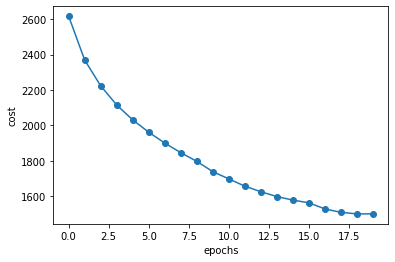

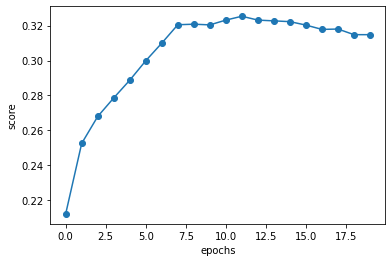

In [ ]:
d = Dataset(source_files, target_files, batch_size=10)
embedding_dim = 50
hidden_dim = 100
num_layers = 2

m = Seq2Seq(d.len_source, d.len_target, embedding_dim, hidden_dim, num_layers=2, 
            padding_dim_source=d.source_pad, padding_dim_target=d.target_pad, start_dim_target=d.target_start)

train_and_save(m, d, "seq2seq_")

##seq_attention

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, padding_dim=0):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_dim)
        self.encoder = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        
    def forward(self, input):
        '''
        input dim => 2d no_sentences * no_words
        make sure that the input is in reverse
        
        Outputs:
        output, h, c
        
        output => dim: (num_sentences * num_words * hidden_dim)
        h => (num_layers * num_sentences * hidden_dim)
        c => (num_layers * num_sentences * hidden_dim)
        '''
        embeddings = self.embedding(input)
        output, (h, c) = self.encoder(embeddings)
        
        return output, h, c

In [ ]:
class Seq2SeqWithAttention(nn.Module):
    def __init__(self, source_vocab_len, target_vocab_len, embedding_dim, hidden_dim, num_layers=1,
                       padding_dim_source=0, start_dim_target=1, padding_dim_target=0):
        super().__init__()
        self.encoder = Encoder(source_vocab_len, embedding_dim, hidden_dim, num_layers, padding_dim_source)
        self.decoder = DecoderAttention(target_vocab_len, embedding_dim, hidden_dim, num_layers, padding_dim_target, start_dim_target)
        
    def forward(self, source_input, target_input=None, source_mask=None):
        output, h, c = self.encoder(source_input)
        return self.decoder(output, h, c, target_input, source_mask=source_mask)
        
class Attention(nn.Module): ##concat score
    def __init__(self, dim):
        super().__init__()
        self.layer1 = nn.Linear(dim * 2, dim)
        self.layer2 = nn.Linear(dim, 1)
        
    def forward(self, source_h, target_h, source_mask=None):
        '''
        source_h => num_sentences * num_words * hidden_dim
        target_h => num_sentences * hidden_dim (only last layer - that's why)
        source_mask => num_sentences * num_words 
        '''
        num_sentences, num_words = source_h.shape[:-1]
        target_h = target_h.repeat(1, num_words).reshape(num_words * num_sentences, -1) #num_sentences*num_words*hidden_dim before reshaping
        mlp_input = torch.cat((target_h, source_h.reshape(num_words * num_sentences, -1)
                              ), dim=1).reshape(num_words * num_sentences, -1) ##num_words*num_sentences*(hidden_dim+hidden_dim)
        
        h1 = torch.tanh(self.layer1(mlp_input))
        h2 = self.layer2(h1)
        
        raw_weights = h2.reshape(num_sentences, num_words)
        
        if source_mask is not None:
            raw_weights = source_mask * raw_weights
        weights = torch.softmax(f.relu(raw_weights), dim=1)
        
        return torch.sum(weights.unsqueeze(-1) * source_h, dim=1)


class DecoderAttention(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, num_layers, padding_dim=0, start_dim=1):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_dim)
        self.decoder = nn.LSTM(embedding_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.word_predictor = nn.Linear(hidden_dim, num_embeddings)
        self.start_dim = start_dim
        
        self.attention = Attention(hidden_dim)
        
    def forward(self, output, h, c, input=None, max_sen_len=20, source_mask=None):
        
        source_h = output
        num_sentences, num_words, hidden_dim = output.shape
        words_selected = torch.LongTensor([[self.start_dim] for _ in range(num_sentences)])

        decoder_context = torch.zeros(num_sentences, hidden_dim)
        pred = []
        
        if input is not None:
            max_sen_len = input.shape[1]
            teacher_words = input.t()
        
        for i in range(max_sen_len):
            embeddings = self.embedding(words_selected)
            decoder_input = torch.cat((embeddings, decoder_context.unsqueeze(1)), dim=-1) #(num_sentences * num_words * embedding_dim+hidden_dim)
            y_t, (h, c) = self.decoder(decoder_input, (h, c))
            orig_shape = y_t.shape
            pred_t = self.word_predictor(y_t.reshape(orig_shape[0]*orig_shape[1], 
                                                     -1)).reshape(*orig_shape[:-1], -1).squeeze(1)
            pred.append(pred_t)
            decoder_context = self.attention(source_h, h[-1], source_mask)
            
            if input is None:
                words_selected = torch.max(pred_t, dim=1)[1].unsqueeze(1)
            else: #teacher enforcing
                words_selected = teacher_words[i].unsqueeze(1)


        pred = torch.stack(pred, dim=1)
        return torch.log_softmax(pred, dim=-1)


loss  tensor(2703.5852, grad_fn=<AddBackward0>)
Input:  i designed this ship .
Target:  मैं इस जहाज बनाया गया ।
Output:  मैं मैं । । । । । । ।

Input:  life never forgives weakness .
Target:  जीवन कभी कमजोरी को माफ नहीं करती है ।
Output:  मैं एक । । । । । । । ।

Input:  l want my life .
Target:  मैं अपनी जान चाहता हूँ ।
Output:  मैं एक । । । । । । ।

Input:  no , sir , i have not .
Target:  नहीं सर , मैं नहीं किया है ।
Output:  यह , , , , , । ।

Input:  i ordered a full sealing .
Target:  मैं एक पूर्ण सीलिंग का आदेश दिया ।
Output:  मैं मैं नहीं । । । । । । । ।

Input:  hows rosie doing , jim ?
Target:  कैसे रोजी , जिम कर रहा है ?
Output:  आप , , , है

Input:  prepare for stage one separation .
Target:  पहले चरण के अलगाव के लिए तैयार रहे ।
Output:  यह एक नहीं । । । । । । । ।

Input:  always complaining about work .
Target:  हमेशा काम के बारे में शिकायत ।
Output:  मैं एक । । । । । । ।

Input:  history rewards the bold .
Target:  इतिहास पुरस्कार बोल्ड ।
Output:  मैं एक । । । । । ।



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input:  your father became a butterfly ?
Target:  तुम्हारे पिता एक तितली बन गए ?
Output:  आप क्या क्या ? ? ? ?

Input:  making everyone so residents elysium .
Target:  हर कोई इतना निवासियों नन्दन बनाना ।
Output:  मैं मैं नहीं । । । । । । । ।

Input:  you must crucify him !
Target:  तुम्हें उसे फांसी पर चढ़ाना ही चाहिए !
Output:  आप आप है

Input:  i just thought since we . . .
Target:  मैं सिर्फ हम के बाद सोचा था कि । । ।
Output:  मैं मैं । । । । । । । । । । । ।

Input:  but whats the point , alexander ?
Target:  लेकिन मुद्दा यह है , अलेक्जेंडर क्या है ?
Output:  आप , , , है

Input:  its the moment of truth .
Target:  यह सच्चाई का क्षण है ।
Output:  मैं एक । । । । । । । । ।

Input:  ( breathing heavily )
Target:  (श्वास भारी )
Output:  ) )

Input:  ill call you back later .
Target:  मैं तुम्हें बाद में वापस फोन करूंगा ।
Output:  मैं मैं मैं । । । । । । । ।

Input:  in . . . . . . . . .
Target:  में । । । । । । । । ।
Output:  मैं । । । । । । । । । । । ।

Input:  thats a rich bet .
Target

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input:  i was not paying attention .
Target:  अरे तातसुहेइ ! मैंने ध्यान नहीं दिया ।
Output:  मैं मैं मैं । । । । । । । ।

Input:  but hes still going down .
Target:  लेकिन वह अभी भी नीचे जा रहा है ।
Output:  मैं एक नहीं । । । । । ।

Input:  i am taking you back .
Target:  मैं तुम्हें वापस ले रहा हूँ।
Output:  मैं मैं मैं । । । । । । । ।

Input:  you are a useless cadet .
Target:  तुम एक बेकार खेतिहर हो ।
Output:  मैं मैं नहीं । । । । । । । ।

Input:  you have until dawn .
Target:  आप सुबह तक है ।
Output:  मैं मैं । । । । । । ।

Input:  im tired of starting over .
Target:  मैं से शुरू कर के थक गया हूँ ।
Output:  मैं मैं नहीं । । । । । । ।

Input:  but its all so easy
Target:  लेकिनयहसब इतनाआसान
Output:  आप आप है

Input:  (the day by moby )
Target:  (mobyबदिन )
Output:  ) )

Input:  its a long time .
Target:  यह एक लंबा समय है ।
Output:  मैं एक । । । । । । ।

Input:  any fool would understand it .
Target:  कोई बेवकूफ़ भी समझ सकता है ।
Output:  यह एक नहीं । । । । । ।

Input:  are you a ki

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
Input:  come on , dick splash .
Target:  , डिक छप चलो ।
Output:  चलो से , ! । । । । । से । । । । । । । । । ।

Input:  what have you done ?
Target:  तुम क्या किया है ?
Output:  क्या क्या है ?

Input:  we are on final approach .
Target:  हम क़रीब पहुंच रहे हैं।
Output:  हम उन पर पर रहे रहे । । । भाग्यशाली । हैं।

Input:  with the secretary of treasury ?
Target:  राजकोष के सचिव के साथ ?
Output:  की की की हैं।

Input:  the office is closed tomorrow .
Target:  कार्यालय में कल बंद कर दिया है ।
Output:  हमारे ? किया है

Input:  this is real shot !
Target:  ये सच है !
Output:  यह बेटे की है ! दो ! ! ! है

Input:  do not forget your clips .
Target:  अपने क्लिप को मत भूलना ।
Output:  अपने अपने नहीं अपने नहीं । । । । । । मेरे । ?

Input:  dufresne . ? andy , let me out .
Target:  एंडी , मुझे बाहर निकालो ।
Output:  अब है और । । । । नहीं । । और है

Input:  first day of panda training !
Target:  पांडा प्रशिक्षण का पहला दिन !
Output:  हमें हर की की क

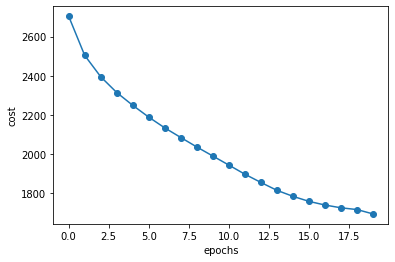

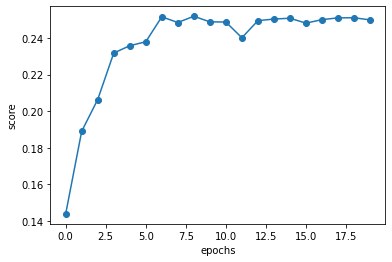

In [ ]:
d = Dataset(source_files, target_files, batch_size=10)
embedding_dim = 50
hidden_dim = 100
num_layers = 2


m = Seq2SeqWithAttention(d.len_source, d.len_target, embedding_dim, hidden_dim, num_layers=2, 
            padding_dim_source=d.source_pad, padding_dim_target=d.target_pad, start_dim_target=d.target_start)

train_and_save(m, d, "attention_")


#Without punctuation


##data prep


In [ ]:
# import pandas as pd
df = pd.read_pickle('en_hi.pkl')

In [ ]:
df.head(20)

,english,hindi
57382,Who is this man?\n,-ये आदमी कौन है ?\n
28149,And the other brother?\n,और दूसरे भाई?\n
80284,"- Greetings, Mustakeen bhai.\n","नमस्ते, Mustakeen भाई।\n"
63596,"Please, reason with them.\n","कृपया, उन लोगों के साथ कारण.\n"
9459,There's a howling gale.\n,तेज़ हवा आ रही है।\n
67410,"- No, you don't.\n","- नहीं , कभी नहीं .\n"
89506,"the violence, the rage.\n","हिंसा, स्पूर्ति।\n"
71637,Signal decoy in place.\n,सिग्नल जगह में लूभाव।\n
66488,You guys come with?\n,तुम लोग इसे ले तो आये हो ?\n
52809,How long you staying?\n,तुम कब तक रह?\n


In [ ]:
lines = df.copy()
# general
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'t", " not", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"\'re", " are", x))
# lines['english']=lines['english'].apply(lambda x: re.sub(r"\'s", " is", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'d", " would", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'ll", " will", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'ve", " have", x))
lines['english']=lines['english'].apply(lambda x: re.sub(r"n\'m", " am", x))

lines['hindi'] = lines['hindi'].apply(lambda x: x.replace('.',' ।'))
# lines['hindi'] = lines['hindi'].apply(lambda x: x.replace('।',' ।'))

# lines['english']=lines['english'].apply(lambda x: re.sub(r"n\in'", "ing", x))

# Lowercase all characters
lines['english']=lines['english'].apply(lambda x: x.lower())
lines['hindi']=lines['hindi'].apply(lambda x: x.lower())


exclude = set(['$','&','+',':',';','=','@','|','<','>','^','*','%','-','#','\'','।']) # Set of all special characters
# Remove all the special characters
lines['english']=lines['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi']=lines['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

exclude = set(string.punctuation)
# Remove all the special characters
lines['english']=lines['english'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines['hindi']=lines['hindi'].apply(lambda x: ''.join(ch for ch in x if ch not in exclude))


# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines['english']=lines['english'].apply(lambda x: x.translate(remove_digits))
lines['hindi']=lines['hindi'].apply(lambda x: x.translate(remove_digits))

lines['hindi'] = lines['hindi'].apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

# Remove extra spaces
lines['english']=lines['english'].apply(lambda x: x.strip())
lines['hindi']=lines['hindi'].apply(lambda x: x.strip())
lines['english']=lines['english'].apply(lambda x: re.sub(" +", " ", x))
lines['hindi']=lines['hindi'].apply(lambda x: re.sub(" +", " ", x))

# Add start and end tokens to target sequences
lines['hindi'] = lines['hindi'].apply(lambda x :  x + '\n')

lines['english'] = lines['english'].apply(lambda x : x + '\n')
lines.head(20)

,english,hindi
57382,who is this man\n,ये आदमी कौन है\n
28149,and the other brother\n,और दूसरे भाई\n
80284,greetings mustakeen bhai\n,नमस्ते mustakeen भाई\n
63596,please reason with them\n,कृपया उन लोगों के साथ कारण\n
9459,theres a howling gale\n,तेज़ हवा आ रही है\n
67410,no you do not\n,नहीं कभी नहीं\n
89506,the violence the rage\n,हिंसा स्पूर्ति\n
71637,signal decoy in place\n,सिग्नल जगह में लूभाव\n
66488,you guys come with\n,तुम लोग इसे ले तो आये हो\n
52809,how long you staying\n,तुम कब तक रह\n


In [ ]:
train, test = np.split(lines.sample(frac=1), [int(.8*len(df))])
print(train.shape,  test.shape)

(8000, 2) (2000, 2)


In [ ]:
# with open('/content/drive/My Drive/NeuralMT/data/dev.en', 'w') as writefile:
#     writefile.write(('').join(validate['english']))
# with open('/content/drive/My Drive/NeuralMT/data/dev.hi', 'w') as writefile:
#     writefile.write(('').join(validate['hindi']))
with open('/content/drive/My Drive/NeuralMT/data_noPunc/test.en', 'w') as writefile:
    writefile.write(('').join(test['english']))
with open('/content/drive/My Drive/NeuralMT/data_noPunc/test.hi', 'w') as writefile:
    writefile.write(('').join(test['hindi']))
with open('/content/drive/My Drive/NeuralMT/data_noPunc/train.en', 'w') as writefile:
    writefile.write(('').join(train['english']))
with open('/content/drive/My Drive/NeuralMT/data_noPunc/train.hi', 'w') as writefile:
    writefile.write(('').join(train['hindi']))

# with open('/content/drive/My Drive/NeuralMT/data_small/dev.en', 'w') as writefile:
#     writefile.write(('').join(validate['english']))
# with open('/content/drive/My Drive/NeuralMT/data_small/dev.hi', 'w') as writefile:
#     writefile.write(('').join(validate['hindi']))
# with open('/content/drive/My Drive/NeuralMT/data_small/test.en', 'w') as writefile:
#     writefile.write(('').join(test['english']))
# with open('/content/drive/My Drive/NeuralMT/data_small/test.hi', 'w') as writefile:
#     writefile.write(('').join(test['hindi']))
# with open('/content/drive/My Drive/NeuralMT/data_small/train.en', 'w') as writefile:
#     writefile.write(('').join(train['english']))
# with open('/content/drive/My Drive/NeuralMT/data_small/train.hi', 'w') as writefile:
#     writefile.write(('').join(train['hindi']))

##seq2seq

In [ ]:
data_folder = "data_noPunc"
files = os.listdir(data_folder)
source_files = [os.path.join(data_folder, file) for file in files if ".en" in file]
target_files = [os.path.join(data_folder, file) for file in files if ".hi" in file]
print(source_files)

def generate_vocab(filenames):
    vocab = set()
    # no_words = 0
    for file in filenames:
        content = open(file).read()
        sentences = [sentence.split() for sentence in content.split('\n')]
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab.add(word)
                    # no_words += 1

    vocab = {word: num for num, word in enumerate(vocab)}
    return vocab

def parse_files_to_indices(filename, vocab):
    content = open(filename).read()
    return [[vocab[word] for word in sentence.split() if word in vocab] for sentence in content.split('\n')]

class Dataset:
    def __init__(self, source_files, target_files, batch_size=10):
        self.source_vocab = generate_vocab(source_files) #for entire lang
        self.target_vocab = generate_vocab(target_files) #for entire lang
        
        self.len_source = len(self.source_vocab.keys())
        self.source_pad, self.source_start, self.source_end = self.len_source + 2, self.len_source + 1, self.len_source
        self.len_target = len(self.target_vocab.keys())
        self.target_pad, self.target_start, self.target_end = self.len_target + 2, self.len_target + 1, self.len_target
        
        self.source_vocab['<pad>'], self.source_vocab['<start>'], self.source_vocab['<end>'] = [self.source_pad, 
                                                                                                self.source_start, 
                                                                                                self.source_end]
        self.target_vocab['<pad>'], self.target_vocab['<start>'], self.target_vocab['<end>'] = [self.target_pad,
                                                                                                self.target_start, 
                                                                                                self.target_end]
                                                                                              
        ##created indices for <pad>, <start> and <end> tokens
        self.len_source = len(self.source_vocab.keys())
        self.len_target = len(self.target_vocab.keys())
        
        ##inverse vocab for entire lang
        self.source_vocab_inv = {value:key for key, value in self.source_vocab.items()}
        self.target_vocab_inv = {value:key for key, value in self.target_vocab.items()}
        
        ##parsing files into indices
        for filename in source_files:
            if 'train' in filename:
                self.source_train = parse_files_to_indices(filename, self.source_vocab)
            if 'test' in filename:
                self.source_test = parse_files_to_indices(filename, self.source_vocab)
            # if 'dev' in filename:
            #     self.source_dev = parse_files_to_indices(filename, self.source_vocab)
                
        for filename in target_files:
            if 'train' in filename:
                self.target_train = parse_files_to_indices(filename, self.target_vocab)
            if 'test' in filename:
                self.target_test = parse_files_to_indices(filename, self.target_vocab)
            # if 'dev' in filename:
            #     self.target_dev = parse_files_to_indices(filename, self.target_vocab)
                
        ##random shuffling of training data before splitting into batches    
        self.indices = list(range(len(self.source_train)))
        random.shuffle(self.indices)
        self.current = -batch_size
        self.batch_size = batch_size
        
    def __get_batch_input(self, indices):
        source, target_input, target_target = [], [], []
        
        # padding length of sentence
        source_max_len = max(len(self.source_train[i]) for i in indices)
        target_max_len = max(len(self.target_train[i]) for i in indices)
        
        for i in indices:
            length = len(self.source_train[i])
            # reverse_source_sentences and pad at beginning
            sentence = [self.source_pad for _ in range(source_max_len - length)] + [self.source_end] + self.source_train[i][::-1] + [self.source_start]
            source.append(sentence)
            
            length = len(self.target_train[i])
            # padding at end for target
            sentence = [self.target_start] + self.target_train[i] + [self.target_end] + [self.target_pad for _ in range(target_max_len - length)]
            target_input.append(sentence)
            #removed <sos> and put <pad> at end
            target_target.append(sentence[1:] + [self.target_pad])
            
        return np.array(source), np.array(target_input), np.array(target_target)
    
    def get_batch_input(self):
        if self.current > len(self.indices) - self.batch_size:
            self.current = 0
            return None, None, None
        self.current += self.batch_size
        return self.__get_batch_input(self.indices[self.current: self.current + self.batch_size])
    
    def convert_indices_to_words(self, indices):
        output = []
        for sentence in indices:
            s = []
            for word in sentence:
                if word == self.target_end:
                  break
                s.append(self.target_vocab_inv[word])
            output.append(s)
        return output

    def convert_indices_to_words_eng(self, indices):
        output = []
        for sentence in indices:
            s = []
            for word in sentence:
                s.append(self.source_vocab_inv[word])
            output.append(s)
        return output

['data_noPunc/test.en', 'data_noPunc/train.en']


loss  tensor(2748.4453, grad_fn=<AddBackward0>)
Input:  just go to hell
Target:  बस भाड़ में जाओ
Output:  यह के लिए

Input:  yes we have been there
Target:  हाँ हम वहाँ किया गया है
Output:  यह एक के लिए है

Input:  what did you say
Target:  क्या कहा तुमने
Output:  आप तुम

Input:  or well all die together
Target:  या हम सब एक साथ मरेंगे
Output:  यह यह के लिए है

Input:  i am in trouble again
Target:  मैं मुसीबत में फिर से हूँ
Output:  मैं यह के लिए

Input:  what makes you so sure
Target:  तुम इतना यकीन है कि क्या करता है
Output:  आप आप के लिए

Input:  that you know of
Target:  आप के बारे में पता है
Output:  आप तुम

Input:  right who wants some bubbly
Target:  तुम्हें विंसेंट के बगल में नहीं बैठना चाहिए
Output:  यह एक के लिए

Input:  we keep on running
Target:  हम चल रहे हैं पर रहते हैं
Output:  यह एक में है

Input:  switching to instruments now
Target:  अब उपकरणों को स्विच करना
Output:  यह एक के लिए



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input:  it comes back the memory
Target:  यह स्मृति वापस आता है
Output:  यह एक के लिए

Input:  it brings back sad memories
Target:  यह वापस दुखद यादें लाती है
Output:  मैं एक के लिए लिए

Input:  have a good day
Target:  एक अच्छा दिन है
Output:  यह एक के लिए

Input:  no i told you
Target:  नहीं मैंने तुमसे कहा था
Output:  मैं तुम तुम

Input:  no let me see
Target:  नहीं मुझे देखते हैं
Output:  मैं यह के लिए

Input:  lannisters do not act like fools
Target:  lannisters मूर्खों की तरह कार्य नहीं करते हैं
Output:  मैं यह नहीं है

Input:  your memory is not destroyed
Target:  आपकीस्मृति नष्ट नहीं है
Output:  यह एक के लिए

Input:  happy hunting mr wick
Target:  हैप्पी शिकार श्री विक
Output:  यह एक में है

Input:  no do not think so
Target:  नहीं ऐसा नहीं लगता
Output:  मैं एक नहीं है

Input:  you comin in awfully late
Target:  तुम भय देर में आ रही
Output:  आप आप के लिए लिए

Input:  i do not know honestly
Target:  मुझे नहीं पता है ईमानदारी से
Output:  मैं तुम नहीं नहीं

Input:  im a bird po
Ta

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
Input:  yeah im on it
Target:  हाँ मैं उस पर हूँ
Output:  मैं यह में है

Input:  this evenings session is adjourned
Target:  इस शाम की बैठक स्थगित होती है
Output:  यह एक के लिए

Input:  im just doing my job
Target:  मैं सिर्फ अपना काम कर रहा हूँ
Output:  मैं मैं एक के लिए

Input:  innocent men do not run
Target:  मासूम पुरुषों नहीं चला है
Output:  यह एक के लिए

Input:  how are you not dead
Target:  कैसे तुम मर नहीं रहे हैं
Output:  तुम तुम नहीं

Input:  we are on fire
Target:  आग लगा दी है
Output:  यह एक है

Input:  you did that on purpose
Target:  आप उद्देश्य पर किया
Output:  आप आप में

Input:  i watched you burn
Target:  मैंने तुम्हें आग में जलते देखा था
Output:  आप तुम क्या

Input:  do you trust me
Target:  आप मुझ पर विश्वास करते हैं
Output:  तुम तुम तुम

Input:  i ca not send you there
Target:  मैं तुम्हें वहाँ नहीं भेज सकता
Output:  मैं तुम तुम नहीं हैं

Input:  you knew it right
Target:  तुम्हें पता था न
Output:  आप तुम तुम

Inpu

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
Input:  its in the back
Target:  यह पीठ में है
Output:  यह वापस है

Input:  did she get hiv too
Target:  वह भी एचआईवी मिलता है
Output:  वह सिर्फ भी थी

Input:  does not matter now
Target:  अब कोई फ़र्क नहीं पड़ता
Output:  वह कोई अब नहीं है

Input:  unfortunately i do know you
Target:  दुर्भाग्य से मैं तुम्हें पता नहीं है
Output:  लेकिन मैं तुम्हें पता है

Input:  it began to snow
Target:  बर्फ शुरू हो गयी
Output:  यह का क्या हुआ है

Input:  not the fucking desk ronnie
Target:  नहीं डेस्क नहीं रॉनी
Output:  यह क्यों मत मिलता है

Input:  hell never answer to you
Target:  उन्होंने कहा कि आप का जवाब कभी नहीं होगा
Output:  मैं तुम्हें कभी नहीं कर रहा हूँ

Input:  do not leave me alone
Target:  मुझे अकेला मत छोड़ो
Output:  नहीं मुझे मत दे

Input:  © prm nder mnköö ™
Target:  © पीआर एम ndeआरएम nköö
Output:  © पीआर एम nderएम nköö 

Input:  anyone else can stay
Target:  और कोई रुक सकता है
Output:  वह फिर से बाहर कर सकता है

Input:  the cloning 

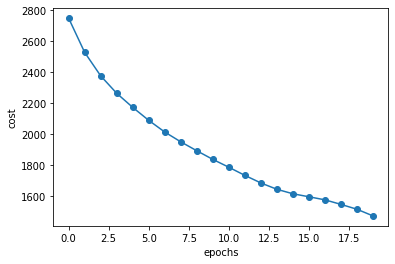

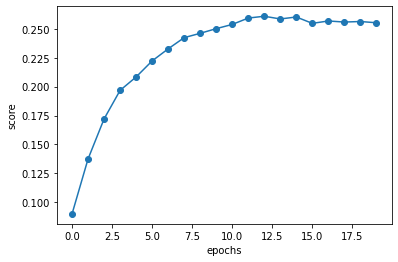

In [ ]:
d = Dataset(source_files, target_files, batch_size=10)
embedding_dim = 50
hidden_dim = 100
num_layers = 2

m = Seq2Seq(d.len_source, d.len_target, embedding_dim, hidden_dim, num_layers=2, 
            padding_dim_source=d.source_pad, padding_dim_target=d.target_pad, start_dim_target=d.target_start)
#print(m.cuda())
train_and_save(m, d, "seq2seq_noPunc")

##seq2seq_attention


loss  tensor(2769.9888, grad_fn=<AddBackward0>)
Input:  just go to hell
Target:  बस भाड़ में जाओ
Output:  यह एक

Input:  yes we have been there
Target:  हाँ हम वहाँ किया गया है
Output:  यह एक के

Input:  what did you say
Target:  क्या कहा तुमने
Output:  आप तुम

Input:  or well all die together
Target:  या हम सब एक साथ मरेंगे
Output:  यह एक के

Input:  i am in trouble again
Target:  मैं मुसीबत में फिर से हूँ
Output:  मैं एक एक

Input:  what makes you so sure
Target:  तुम इतना यकीन है कि क्या करता है
Output:  आप एक के

Input:  that you know of
Target:  आप के बारे में पता है
Output:  आप तुम

Input:  right who wants some bubbly
Target:  तुम्हें विंसेंट के बगल में नहीं बैठना चाहिए
Output:  यह एक के



/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Input:  we keep on running
Target:  हम चल रहे हैं पर रहते हैं
Output:  यह एक

Input:  switching to instruments now
Target:  अब उपकरणों को स्विच करना
Output:  यह एक

Input:  it comes back the memory
Target:  यह स्मृति वापस आता है
Output:  यह एक के

Input:  it brings back sad memories
Target:  यह वापस दुखद यादें लाती है
Output:  मैं एक के

Input:  have a good day
Target:  एक अच्छा दिन है
Output:  यह एक के

Input:  no i told you
Target:  नहीं मैंने तुमसे कहा था
Output:  मैं तुम नहीं

Input:  no let me see
Target:  नहीं मुझे देखते हैं
Output:  मैं एक

Input:  lannisters do not act like fools
Target:  lannisters मूर्खों की तरह कार्य नहीं करते हैं
Output:  यह एक के

Input:  your memory is not destroyed
Target:  आपकीस्मृति नष्ट नहीं है
Output:  यह एक है

Input:  happy hunting mr wick
Target:  हैप्पी शिकार श्री विक
Output:  यह एक के

Input:  no do not think so
Target:  नहीं ऐसा नहीं लगता
Output:  मैं नहीं नहीं

Input:  you comin in awfully late
Target:  तुम भय देर में आ रही
Output:  मैं एक के


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
Input:  edward whats wrong
Target:  एडवर्ड क्या हुआ
Output:  मैं एक

Input:  where is he
Target:  कहाँ है
Output:  यह है

Input:  you ever been here before
Target:  आप कभी यहाँ से पहले किया गया
Output:  आप तुम नहीं

Input:  we gotta go fast
Target:  हम तेजी से जाना होगा
Output:  यह एक

Input:  order must be restored
Target:  शांति बहाल होनी चाहिए
Output:  यह एक के

Input:  bullshit when can we go
Target:  बकवास है जब हम जा सकते हैं
Output:  यह एक के

Input:  im his only living relative
Target:  मैं अपने ही रहने वाले रिश्तेदार हूँ
Output:  मैं एक के के

Input:  i need your help
Target:  मैं तुम्हारी मदद की जरूरत है
Output:  मैं एक के

Input:  absolutely mr vice president
Target:  वाइस प्रेज़ीडेंट
Output:  यह एक के

Input:  you scratch it here sideways
Target:  तुम यहाँ scratch करो साइड से
Output:  आप तुम नहीं

Input:  has your leg grown back
Target:  क्या आप एक और पैर बढ़ रहे हैं
Output:  यह एक के

Input:  no she is different
Target:  न

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


Streaming output truncated to the last 5000 lines.
Input:  its in the back
Target:  यह पीठ में है
Output:  यह समय है

Input:  did she get hiv too
Target:  वह भी एचआईवी मिलता है
Output:  हम उसे कहा नहीं था था था

Input:  does not matter now
Target:  अब कोई फ़र्क नहीं पड़ता
Output:  नहीं यह नहीं

Input:  unfortunately i do know you
Target:  दुर्भाग्य से मैं तुम्हें पता नहीं है
Output:  मैं नहीं मैं जानता

Input:  it began to snow
Target:  बर्फ शुरू हो गयी
Output:  मैं करने लिए लिए लिए है

Input:  not the fucking desk ronnie
Target:  नहीं डेस्क नहीं रॉनी
Output:  मुझे तो नहीं

Input:  hell never answer to you
Target:  उन्होंने कहा कि आप का जवाब कभी नहीं होगा
Output:  नहीं तुम्हें तुम्हें नहीं

Input:  do not leave me alone
Target:  मुझे अकेला मत छोड़ो
Output:  मुझे मत मुझे मत

Input:  © prm nder mnköö ™
Target:  © पीआर एम ndeआरएम nköö
Output:  © पीआर nderएम nköö

Input:  anyone else can stay
Target:  और कोई रुक सकता है
Output:  वे कर हैं वे कर हैं

Input:  the cloning of jesus
Target:  यीश

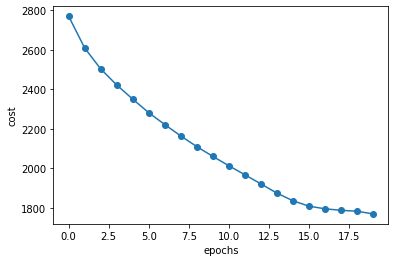

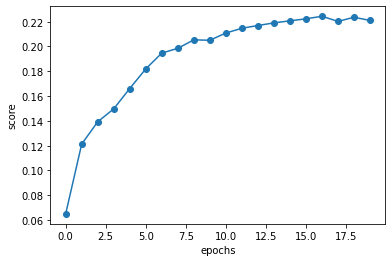

In [ ]:
d = Dataset(source_files, target_files, batch_size=10)
embedding_dim = 50
hidden_dim = 100
num_layers = 2

m = Seq2SeqWithAttention(d.len_source, d.len_target, embedding_dim, hidden_dim, num_layers=2, 
            padding_dim_source=d.source_pad, padding_dim_target=d.target_pad, start_dim_target=d.target_start)

train_and_save(m, d, "attention_noPunc")
